In [1]:
using DrWatson
@quickactivate "BNP2"
using Turing
using StatsPlots: StatsPlots
const splot = StatsPlots.plot
using Revise, BNP2

┌ Info: Precompiling BNP2 [11504357-4fe5-5405-981c-8cd43ea31635]
└ @ Base loading.jl:1273


In [2]:
args = (
    dt        = 0.1,
    dt_fine   = 0.05,
    σ         = 0.1, 
    alg       = NUTS(50, 0.65),
    n_samples = 100,
)

;

In [80]:
data =
let mass = 1.0, position = [0.0, 0.0], velocity = [10.0, 20.0], T = 20
    obj = Particle(mass, position, velocity)
    env = WithStatic(Space(obj), EARTH)
    traj = simulate(env, PymunkSimulator(args.dt), 2T)
    HTML(animof([env, traj...]; do_tracklocal=false).to_html5_video()) |> display
    
    traj = traj[1:T]
    states = add_gaussiannoise(vec.(stateof.(traj)), args.σ)
    (obj0=obj, traj=traj, states=states)
end

;

HTML{String}("<video width=\"500\" height=\"500\" controls autoplay loop>\n  <source type=\"video/mp4\" src=\"data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAAe2W1kYXQAAAKhBgX//53cRem9\n5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENv\ncHlsZWZ0IDIwMDMtMjAxNyAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9w\ndGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1o\nZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2\nIGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0\nX3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE2IGxvb2thaGVhZF90aHJlYWRz\nPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9j\nb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0\nPTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWlu\ndD0yNTAga2V5aW50X21pbj0yMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2Fo\nZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9\nNjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAADjdliIQAN//+9vD+BTY7mNCX\nEc3onTMfvxW4ujQ3vc4AAAMAAAMADuPlocG+vHIc0AAAWwAGWbfzhEj8xQEA3Pb/v+qc9yMlSTON\n5tuYtLH2TuvjLoGoDKCw8srpO43OJLUcViC9nrvtgq+ZMcE5AMMBIhjUPjs2RwyfimXonbcSDSSs\n1leI0NXI352wnJytMa+b11MZl/WkxRTOxW4ynDPcyiokDoF7xZQYps3JmqNb8aScOcU/bMq8GEsQ\nNHcpb+iEJ5em0w5q34kvKBjvQM/UM4AAAAMAEz7x/cWXXhhHbjBdiD9dFUrI+EDV1pxRJp/i78wg\nqDsF8Ktbbq315dQlblkvmrv0vmyzJQbRgiKGFb5D9lI2efboHX5pJ90t9lsNoFx6S8HjmAJ3xiHK\nVZ2FpWfZFULvAk36zo+Qi0tH/s/KMJ0ezbsD+ZbX2xuskmHPAk3HjYDQfoJYN+sRwaKSIiRFHQYb\nDUQzV3tQGvMagNHs141KPWPmDLvo2o4BSq3kxvOcJZYyZiA4s65vTYw4BFCejVt/9BLMN0DDqLiH\nDpzUNB8d/sGkpa1jVa9of+WLCCFvmuXeZsw7gVew5+/vjTbLIolaKe6YPriWRdie08L9nuVt0XCj\nhB/T24fhUOHD71ax5vi+kTXRloBLs2/EqPG6NeuswSRAN+AZBSjgVjtQSvetMnpCgT2Wv4T03qET\nVQkiVzUix0g0qiXMbj2P/+uZquXML3iSZHuXsmRMkNFwa4ES4YC8xVmfteQS6yaVUgGKI23ChJK1\nFsdcfY6e3ciKwhmaPz9CRS1lXAJIuhoObaIEWP8cHJ9KLljSpFD4YYUsmHcJ+tRGdq6L1XI0Wc1b\na08jR7T3qPanAMBzgH40y/MtunTD97PwDdCah1+LLKEVGrPRXRQKmfVwJj9kVCHP4G6GonsMlHbB\na362csgo1adoLRtwstcHIxmBjNXUi915nVSx9LUhyTftDBX0GqfMWQTY4w6B7nd81iiMxmOlpm2O\nX8YaYt+48I37kmzK13Q2O/BT32b5fuec3uXX0faejDTdaqX8xdVQvjMWYlDvpbR2OOZ9hXR0Vp/v\nFw4nvID4/pDW8nqnFLJ0jyMn3x3Q4ZsLCrJh1T/eUj6AhDRI/4HqnEJw992XpMN8SczH2TOt622T\nkgN8ylYiAAoJxN6AGl/EYkgpL23NNH6R1jFP3v+qteJRzH8UWXn3X1KcBuH2fafT4Ju3eYQ/ic3b\n2bnBK8t0AOpsaP31U+iwisL6Fo4M3SlrBLiKHmvLKD8xtroQVB2HIQUn86GUfiCzyQcySE8JL46G\n45jJxb1kzj+P5wldkKhpvYlPJlIves7yZ3tMVxXpY7P44vN3W352msbHsszksIRQlgn4phgXS3ZO\nbyLvETr/IPxdngnf7MwTm7rwGuakuVGdiYvKEo1T5FNHun3XUkTjYZiHR3TZaiQY6Dh8dyobGX1t\n6hQiXcqYHnaqpLrBkJaN5ID1FH5WMq53ZaU3lAE5+AdYGv/BOnHRVVL9O4KgeX3/omf/WsP0K0NN\nZ45g8UNB86mqKJd5c+jIHX/gAgY6zWzvJAAA7AAGtn/mFscJvbXinCYE0JJ/qSgjJoRVf/UNPgfA\ncZAB7n0Apyhc709UvHv65Zo/OeAS5kBhXowPwGHQ6U+lsVu0irSYU3+R1j7MPzlqOz9LKua+COAN\nIro0gYF2TDD111w7/KxjnH9dBYCgcbV6etLLPbu9FINa+ePn5j328ut+tLM3IrJDl3gEMiOoKCgw\nDR7hQlwbHhxXZ9QIYafIpTzHC4mcixH5n5gpWQZG+nbh2KqkCqjclpVJBfi1lcXF3P99dyNhPqlC\nXUEOoaMY7PGDuP/+sPATV+J1zcMqYu5BUpDN7ZULlzrcJTmlBRIuhNbxBrpRF1MI3z25gOQGU7G1\nfpfOiEi5SIzpHc+UTLaU8AtR6mNePeDRaPyH2ewAZ/hHe1Y3IZ2qoW1RWfJmScsaZR60ZXS8sgRS\nfgY87Kx7c6KK+yUlxSfz//0/rssI6ZXC/lGMI/4w6CnI45tUx6lIWxnQ7AmRI5+gkpDWeuVmh3QL\ndAdmAtdyioevx+KyLQa5axMd5a+0IxXNx1heY9xgd3ubEDsutYHmXh3GF1I9uYuUjP8Uf3/eZAoz\nR976kBt31gdX3dC+kDFpdu/2hWb12YeCfzoZRNDFMKnyJ/NcSR/CR18BqJSduWvkZZqpPAX0rZ/t\nOZ8bof47X46KixLQ+6lA7X3O5vTgK0xD6h4BTN3jf6V/dvwUvwaS04qCpek/x8sggTzZrm1UP1UC\n6jqdsu+B2XUvGnb4jRrOR/SHt9m2CkNWEHNwdhdarKHnkoZ5DsLAUsKfIhzfbgC+t7EsTcnL/Eyf\nA6tTHN5r9/kJfcVErGeCLxifIDHwdItBAk6cc3IkvgoDhsmGWxuG/XhKSCI5MVqU0wm8zRJQACgG\nUV3p/oxD43EPVxRJky6SDop8hTKLXjy346pT6Kr15ezziecNc/8+Uo/a4sFKmb9vnLMaho52hnEg\nwm+W62p/7S4sP9V0ips5Df9g+pYoMPO5tLuG5cAD7g+60t2iL+0U0ymfoC6Pps8xHagkggwjKnn6\n0uJQjiIFI0aGt6y1SjuFVK0VwHm3yWf80unmeQ2VWDfDuacOIw5QUG4HBYge2s3h6a5a3OUsY9RP\nHqZ3HcfVgRqRvdIcC+6psqKcSCt31wIrOu9HKtA5pJ42PDbq6Iq6fDBRqPgqaaQLzKzvKG7/3yxD\nZLvyCek+825fX6QAWOIxoMz82yRGDJ9CUY7nxuuRdV++pn

## Single force

┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/kai/.julia/packages/Turing/MoqTc/src/inference/hmc.jl:553


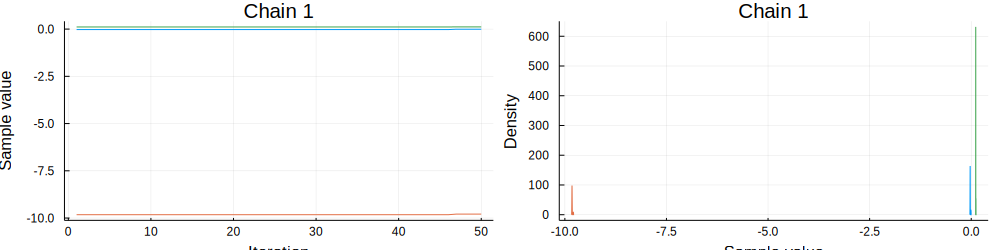

  6.583103 seconds (8.73 M allocations: 499.316 MiB, 9.84% gc time)


In [85]:
@model single_force(obj0, states, dt) = begin
    obj = obj0
    σ ~ InverseGamma(2, 3)
    f ~ MvNormal(zeros(2), 10)
    for t in 1:length(states)
        env = transition(Space(Forced(obj, f)), dt)
        obj = objectof(first(objectsof(env)))
        states[t] ~ MvNormal(vec(stateof(obj)), σ)
    end
end

@time chn = sample(single_force(data.obj0, data.states, args.dt), args.alg, args.n_samples)

splot(chn; colordim=:parameter) |> display

;

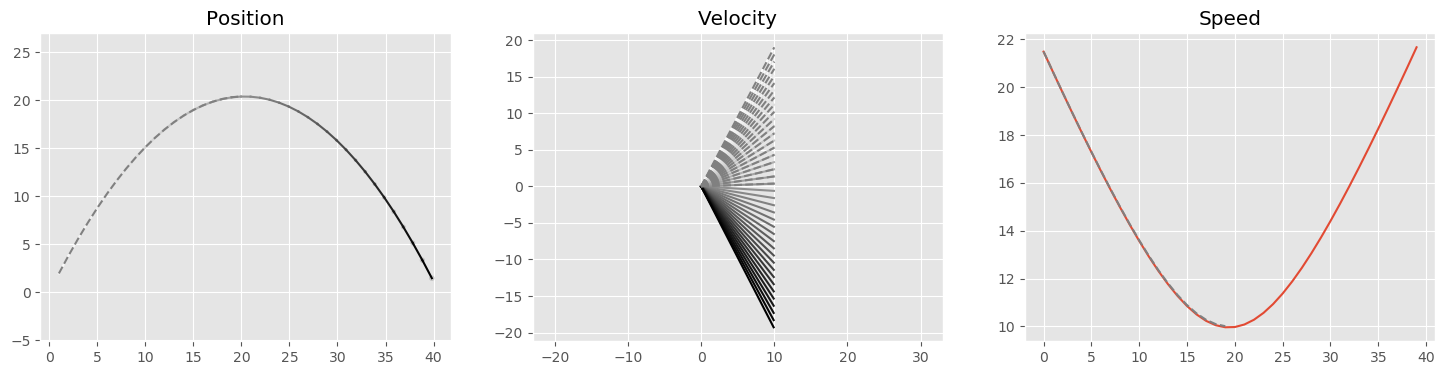

In [86]:
function meantraj(traj_list)
    pos = mean(t.pos for t in traj_list)
    vel = mean(t.vel for t in traj_list)
    return Particle.(1.0, pos, vel)
end

function stdtrajdev(traj_list)
    pos = mean(t.pos for t in traj_list)
    dev = []
    for t in 1:length(pos)
        ps = [traj_list[i].pos[t] for i in 1:length(traj_list)]
        push!(dev, 2 * sqrt(sum(std(ps).^2)))
    end
    return dev
end

function updatedev!(ax, traj_list)
    traj = meantraj(traj_list)
    dev = stdtrajdev(traj_list)
    for t in 1:length(traj)
        c = plt.Circle(tuple(positionof(traj[t])...), dev[t], color="gray", alpha=0.25)
        ax.add_artist(c)
    end
end

let n_mc = 20, res = get(chn[end-n_mc+1:end], [:f]), T = length(data.traj)
    traj_list = []
    for i in 1:n_mc
        f = [res.f[1][i], res.f[2][i]]
        traj = simulate(Space(Forced(data.obj0, f)), args.dt, 2T)
        push!(traj_list, (pos=positionof.(traj), vel=velocityof.(traj)))
    end
    fig, axes = plot(meantraj(traj_list), data.traj)
    updatedev!(first(axes), traj_list)
    display(fig)
end

;

## Single force and particle parameters

┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/kai/.julia/packages/Turing/MoqTc/src/inference/hmc.jl:553


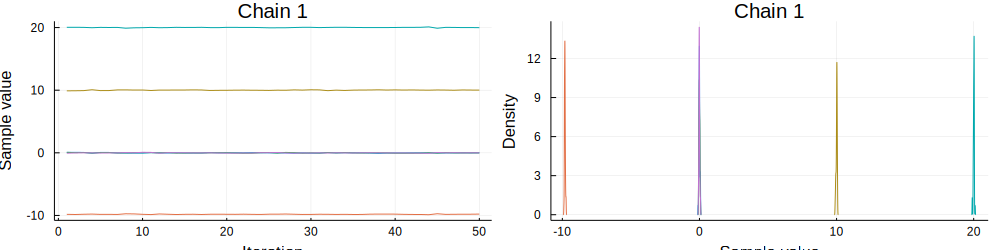

  9.378663 seconds (14.47 M allocations: 895.221 MiB, 4.26% gc time)


In [87]:
@model single_force_all_params(mass, states, dt) = begin
    f ~ MvNormal(zeros(2), 10)
    pos0 ~ MvNormal(zeros(2), 10)
    vel0 ~ MvNormal(zeros(2), 10)
    obj = Particle(mass, pos0, vel0)
    for t in 1:length(states)
        env = transition(Space(Forced(obj, f)), dt)
        obj = objectof(first(objectsof(env)))
        states[t] ~ MvNormal(vec(stateof(obj)), 1e-1)
    end
end

@time chn = sample(single_force_all_params(massof(data.obj0), vec.(stateof.(data.traj)), args.dt), args.alg, args.n_samples)

splot(chn; colordim=:parameter) |> display

;

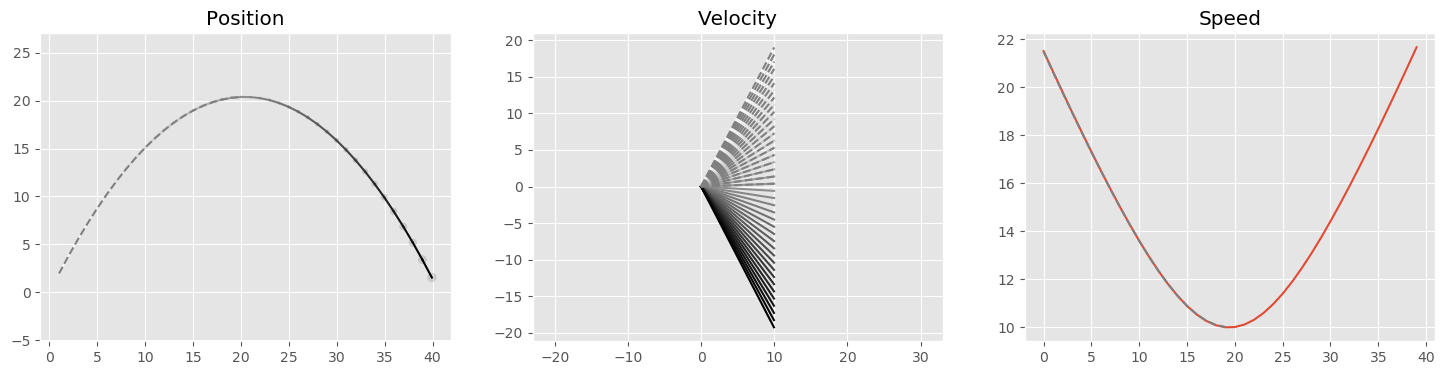

In [89]:
let n_mc = 20, res = get(chn[end-n_mc+1:end], [:f, :mass, :pos0, :vel0]), T = length(data.traj)
    mass = massof(data.obj0)
    traj_list = []
    for i in 1:n_mc
        f = [res.f[1][i], res.f[2][i]]
        pos0 = [res.pos0[1][i], res.pos0[2][i]]
        vel0 = [res.vel0[1][i], res.vel0[2][i]]
        env = Space(Forced(Particle(mass, pos0, vel0), f))
        traj = simulate(env, args.dt, 2T)
        push!(traj_list, (pos=positionof.(traj), vel=velocityof.(traj)))
    end
    fig, axes = plot(meantraj(traj_list), data.traj)
    updatedev!(first(axes), traj_list)
    display(fig)
end

;

In [90]:
data =
let obj0 = Particle(1.0, [0.0, 2.5], [2.5, 0.0]), T = 40,
    bars = [Bar([-5.0, 0.0], [5.0, 0.0]), Bar([5.5, 0.0], [5.5, 5.0])]
    env = WithStatic(Space(obj0), [EARTH, bars...])
    traj = simulate(env, PymunkSimulator(args.dt_fine), 2T)
    HTML(animof([env, traj...]; do_tracklocal=false).to_html5_video()) |> display
    (traj = traj[1:T], obj0 = obj0)
end

;

HTML{String}("<video width=\"500\" height=\"500\" controls autoplay loop>\n  <source type=\"video/mp4\" src=\"data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAAvom1kYXQAAAKhBgX//53cRem9\n5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENv\ncHlsZWZ0IDIwMDMtMjAxNyAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9w\ndGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1o\nZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2\nIGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0\nX3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE2IGxvb2thaGVhZF90aHJlYWRz\nPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9j\nb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0\nPTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWlu\ndD0yNTAga2V5aW50X21pbj0yMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2Fo\nZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9\nNjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAADlFliIQAN//+9vD+BTY7mNCX\nEc3onTMfvxW4ujQ3vc4AAAMAAAMADuPlocG+vHIc0AAAWwAGWbfzhDezFAQDc9v+/+M7+dqs2mru\nZEtYj21lXxBppZ9V1SKyQfkqn5f8smI/N8vxlVwKxEQw9G3tgb4kheD3FNi68Pxw3d0rvf80cwoS\nhgUEdsEEv+PoJ11oxd+5suQuVNGmeF+eCJOvsFhLEaE3BGj+b6Hf7ehP7Yj8p9RDMBbv57yOmm2j\nmrx7pfDZYoC1kHsgCOeZAprCdz+dzj6zNjNJQZADFJ2Wcdg06MBidbovu85/QlT/rea7+pzY8D2q\nGYEIr0L/VqOfDq8pjp2wwoZ2Hx6LnZyJHPp+hETiys4yf9IE9lewcYRz0LvXzl6XaxMLfT1r1Wv9\nDy7cpbwIbuZPS03Qy5JLMiFzZaUiF5QPBPuTuM2S2dOmFQJX5QB4E/+pQJk1hkrLVvGWNI1OZ+Yu\n4L0gocY4C67/RjRWKJlfkb5Za6E8nldK8wexNm8VQWjmfIv0h91zj+j8cUiVhcBsNeO+h5Gnco5c\ndTXm71nChGNBcFxKXVlmQHlkjERkQCA7QXtwNG2fzpNLXhNzI0pmgsUz3/iUBD/eRjCQAdrX2dvi\nY881xDt82Eqg0RvbbahjywA/j+pj778GmnvA4YG0egEc0Ha1JSAAAFoJOlGStgiWy+U1+7lXIxED\nDUKegU422XONU/V7aIlJPBJP+SF1ULpJnSeVsWBWaKIu7dsUMVlY2Kntx24iwxO1zvWSUNzAn7XK\nnHaVlgo+QoByDxMTxzQHdZDvuKADBWkGzUa/fdzPxZAyfj5jE5xzMsJIl0fQOsL61PW6JlE5MzVL\nqyBddk3GOHG5HJbQWiQroe/4lfuZMqottxJWjeTwToS8mfsgkMs7lIdO/EFxPqkf1YpUqzUzMTJB\nr8tYbnI9HKZMP5+rY5cXkb9MVd0F0sfTqG1QdSo45fkB13TJaJNKJlx94AvmqNCmGh7QKVN9AAAp\nwAb31EtVvYQi/yJNBldC+SUNHWfIy0rXnnKLrNpB5uQBdvzX0vYAtOvjpu9iIP4QwnKnYQyq6zym\n5Ne8EzK2987gyDaBWVUcvv2F1gaUer0D1wT5cEkxsHoyGGc2FZavJU4WHjMN6d1fVXyk2B0jbEPS\nK8bF/V3zeMj8WPib2/9nuPZZjSDS/UhmSUAsgf/TjD/+Dz7yyB2v97KSw1cWn/0wcUWfYFmjvlvF\nib2S+uKQJctjb90VdqdRnKZJ8UZLeYcIng4lKtYEbClbmCcIzOWS57D+aeNNFrkJUSfvN8sXNv9Y\nSYB3e2DfLVgE9m1biFqu8sHcz5jGlKYfFd1NoL4JSCZZ8J0OENp/ipCcr8P0jmF5VW4NH+TBBI/K\norBFc4fOIPLRMiDqgC60G6ltIXTvTSw/l1+XqQCDY/ncIZsRkgCMOgXPN4YXvbMcUO6OoUj+GLsJ\n8BJBjGXtZY4Uii5m5z8oMR74gTsAAHn//z/y3ZO9Dg5rKox1F3RtRVetdr9rQSsSCYzGeLvo/mOu\nbbzdUc92Ag7hTY3K8WqlgD7fSZV3odISryzIGfXXEMuqU67ZnKWnvddxcRN5T1AAKhedOksV9pC1\ndj6nDm7J3PSsZgZ619LMm1rZ022n1CX9RsuTZEoBDQU/BKJhP4t464T1q7F6OzFtDVZJ47BMnR4s\nXCRGfzUBXq708lGdcv/OhQX8dyEgphEIsl4RfPPZm7Gmg+wm4lhpxTC88euMZQM5HbtG4e6Aq7zT\nKHS9Z/ABomVFyX1WEh9VPXWHkWDcjvqQ2zQmw3qCXaFSCKGITNu+M/KzRMjPaiZBgMSSLbuAqwNm\nre0omzDbPurSCjnTNWOnjAordVX3gBVfUQn8GAOjWCp+CXSsFoAAG8jHhqdLQooAAAMAAJrB11pB\nnIb6cKhokpc2r6ErAKneANM2q902O8Ab8/CGfJWiBtYK5j+iWLqDYcamujnyXPkh1QyBS9cSy4/h\nG0du1biuffzl4f2iUqjQeHJo1bbMEGWCrKBMg+WRnV8DOWCQkuq2wB69vhyac90MajhHAZ1OmkgA\ngf9P5GY/nTUoSiT/P3+dB5kJx+sU15Vf1NSP49bCINj9wm62Jhzhf46smaXZJSdOf8qfgNHRFYC6\n33MnzQGJlueTBoeGUvORGsX2JC0rVe/81OaSREzD9Oo2yV/KJ10AABlhE7DPDXs4AAADAAR3Wc/b\nvXK7pM+Q2PhZ3z1Q+0HxOJ60REnHGnmGoDowugsQg7cNH/LXGPRJmCEvu2TTZ1OlJFmdSQ5nfNOA\npFdmf58Ooau4+n+b/iWWppqL2Zh4/+FmLVsNBdQ9YnIZlD0WyflOCtS5zPyw+eNZtVrc1C7bMsaJ\nObiZ5mAPfVn+LIKR+D0euQ6qMr4+mexHdCtZsQU2wStHKvWL21VBVLKhyoqvf+ipMewO7WNZicle\nFECX385+YbQqNGaaBNiAK56LHF/fAtJLIwX5lmTXKDJuP2VDuKAneYCYdcPGpAfC5aNIM0+DAXxg\nD9XfmKhScWQqVsi4jIQxuV6NfKzponLYlQPwnz4T1eHwUjH2iJX/qyv+8JYvNyEB6iYD58i5PQxQ\nGplVUMYwIgKKKZ8VRJXkrJb6aF24ALvTV7zfVDwOcbqszvlU/tFyO/qSNWS6++srbF/5GnndPAut\nxd7tdB5rOsZYt4nmXoAAABH5mOOpqgRyXbtRReDAr+BEW+93icPZ0yUBA7YKiCVHUS2yWmlteFxd\nu35CJGhkGzu+eavA06UN1XdtAQ7Fzg1a65MRtt4wGXf9VF

## Each force for each time step

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/kai/.julia/packages/Turing/MoqTc/src/inference/hmc.jl:553


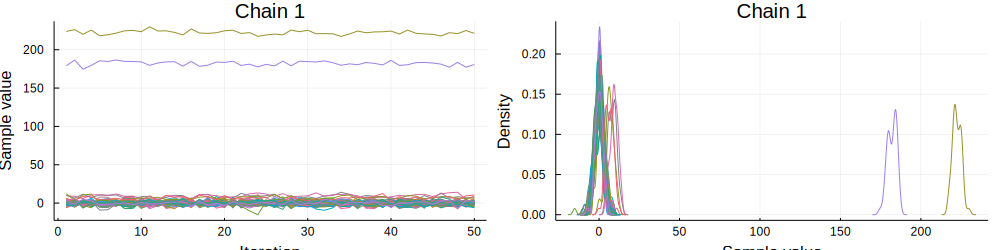

119.428696 seconds (923.22 M allocations: 81.842 GiB, 22.02% gc time)


In [94]:
@model multiple_forces(obj0, states, dt, ::Type{R}=Float64) where {R} = begin
    obj = obj0
    T = length(states)
    F = Vector{Vector{R}}(undef, T)
    for t in 1:T
        F[t] ~ MvNormal(zeros(2), 10)
        env = transition(WithStatic(Space(Forced(obj, F[t])), EARTH), dt)
        obj = objectof(first(objectsof(env)))
        states[t] ~ MvNormal(vec(stateof(obj)), 1e-1)
    end
end

@time chn = sample(multiple_forces(data.obj0, vec.(stateof.(data.traj)), args.dt_fine), args.alg, args.n_samples)

splot(chn; colordim=:parameter) |> display

;

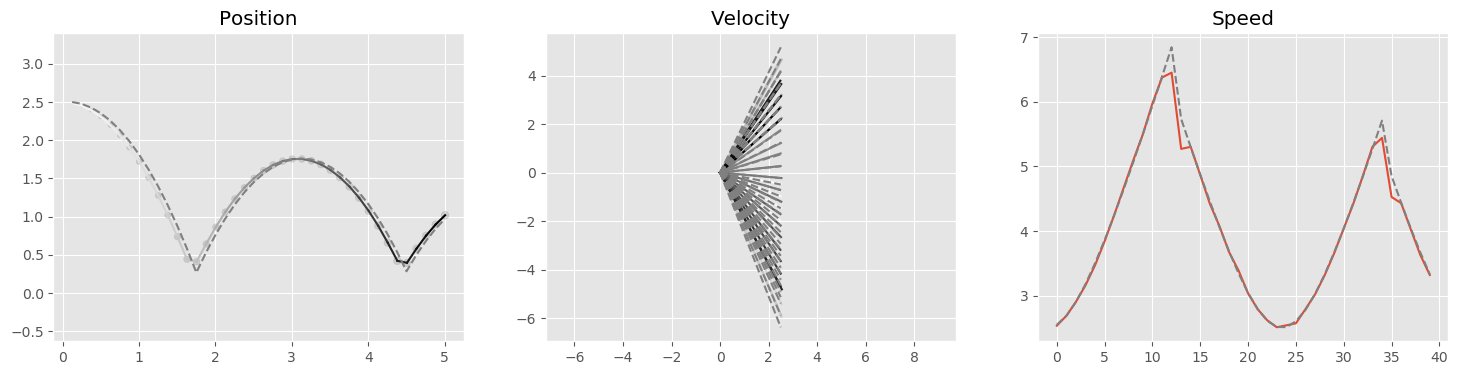

In [97]:
let n_mc = 20, T = length(data.traj)
    chn_sub = get(chn[end-n_mc+1:end], vec([Symbol("F[$t][$i]") for t in 1:T, i in 1:2]))
    traj_list = []
    for i in 1:n_mc
        obj = data.obj0
        traj = Vector{typeof(obj)}(undef, T)
        F = [[chn_sub[Symbol("F[$t][1]")][i], chn_sub[Symbol("F[$t][2]")][i]] for t in 1:T]
        for t in 1:T
            env = transition(WithStatic(Space(Forced(obj, F[t])), EARTH), args.dt_fine)
            obj = objectof(first(objectsof(env)))
            traj[t] = obj
        end
        push!(traj_list, (pos=positionof.(traj), vel=velocityof.(traj)))
    end
    fig, axes = plot(meantraj(traj_list), data.traj)
    updatedev!(first(axes), traj_list)
    display(fig)
end

;